# CosMx Spatial Transcriptomics Analysis Workflow

This notebook provides a comprehensive workflow for analyzing **Nanostring CosMx** spatial transcriptomics data using the SpatialData framework.

## Workflow Overview

1. **Project Setup** - Organize files and create directory structure
2. **Data Loading & Initial QC** - Import CosMx data and perform quality control
3. **FOV Visualization** - Visualize field of views (FOVs) and assign sample IDs
4. **Transcript Quality Metrics** - Assess negative probes and system controls
5. **Cell Filtering & Normalization** - Filter low-quality cells and normalize data
6. **Dimensionality Reduction & Clustering** - PCA, UMAP, and Leiden clustering
7. **Spatial Visualization** - Plot cells and clusters in spatial context
8. **Optional: Resegmentation** - Improve cell segmentation using Cellpose

## Requirements

### Python Modules (must be in your working directory)
- `cosmx.py` - CosMx data reader module
- `sbf.py` - Visualization helper functions
- `reseg.py` - Resegmentation pipeline (optional)
- `reseg_tools.py` - Resegmentation utilities (optional)
- `_constants.py` - CosMx data format constants

### Data Files
CosMx output includes multiple flat files per slide:
- `*_exprMat_file.csv` - Gene expression matrix
- `*_tx_file.csv` - Individual transcript coordinates
- `*_metadata_file.csv` - Cell metadata
- `*_fov_positions_file.csv` - FOV positions
- `*_polygons.csv` - Cell boundary polygons
- `CellComposite/` or `Morphology2D/` - Image directory
- `CellLabels/` - Segmentation masks

---
## 1. Project Setup and File Organization

### Step 1.1: Create Project Directory Structure

Before starting analysis, we need to organize our data and code files properly.

**Required directory structure:**
```
project_folder/
├── cosmx.py                 # CosMx reader module
├── sbf.py                   # Visualization functions
├── reseg.py                 # Resegmentation module (optional)
├── reseg_tools.py           # Resegmentation tools (optional)
├── _constants.py            # Constants definitions
├── cosmx_QC.py              # QC script (reference)
└── flatFiles/               # Data directory
    ├── SLIDE1/              # First slide
    │   ├── SLIDE1_exprMat_file.csv
    │   ├── SLIDE1_tx_file.csv
    │   ├── SLIDE1_metadata_file.csv
    │   ├── SLIDE1_fov_positions_file.csv
    │   ├── SLIDE1_polygons.csv
    │   ├── CellComposite/   # or Morphology2D/
    │   └── CellLabels/
    └── SLIDE2/              # Additional slides...
```

### Step 1.2: File Organization Instructions

**For CosMx data from Nanostring:**

1. **Create main project folder** (e.g., `CosMx_Project/`)
2. **Copy Python modules** to the main folder:
   - `cosmx.py`, `sbf.py`, `_constants.py`
   - Optional: `reseg.py`, `reseg_tools.py`
3. **Create `flatFiles/` directory** in the main folder
4. **Organize slide data:**
   - Create a subdirectory for each slide (e.g., `flatFiles/SLIDE1/`)
   - Move all flat files for that slide into its subdirectory
   - Ensure the image directories (`CellComposite/` and `CellLabels/`) are in each slide folder

**Important Notes:**
- All files for a single slide must be in the same directory
- File naming must follow CosMx conventions (with appropriate suffixes)
- Image directories must be named exactly `CellComposite` or `Morphology2D`
- Label directory must be named exactly `CellLabels`

### Step 1.3: Verify File Structure

In [5]:
import os
import glob

# TODO: Update this path to your project directory
path = "/path/to/folder/"

print("Checking project structure...\n")

# Check for required Python modules
required_modules = ['cosmx.py', 'sbf.py', '_constants.py']
optional_modules = ['reseg.py', 'reseg_tools.py', 'cosmx_QC.py']

print("Required modules:")
for module in required_modules:
    if os.path.exists(os.path.join(path, module)):
        print(f"  ✓ {module}")
    else:
        print(f"  ✗ {module} - MISSING!")

print("\nOptional modules:")
for module in optional_modules:
    if os.path.exists(os.path.join(path, module)):
        print(f"  ✓ {module}")
    else:
        print(f"  - {module} - not found")

# Check for flatFiles directory
flatfiles_dir = os.path.join(path, 'flatFiles')
if os.path.exists(flatfiles_dir):
    print(f"\n✓ flatFiles/ directory found")
    
    # List slide directories
    slides = [d for d in os.listdir(flatfiles_dir) if os.path.isdir(os.path.join(flatfiles_dir, d))]
    print(f"\nFound {len(slides)} slide(s):")
    for slide in slides:
        print(f"  - {slide}")
        slide_path = os.path.join(flatfiles_dir, slide)
        
        # Check for required files
        has_expr = len(glob.glob(os.path.join(slide_path, '*exprMat_file.csv'))) > 0
        has_tx = len(glob.glob(os.path.join(slide_path, '*tx_file.csv'))) > 0
        has_meta = len(glob.glob(os.path.join(slide_path, '*metadata_file.csv'))) > 0
        has_fov = len(glob.glob(os.path.join(slide_path, '*fov_positions_file.csv'))) > 0
        has_poly = len(glob.glob(os.path.join(slide_path, '*polygons.csv'))) > 0
        has_images = os.path.exists(os.path.join(slide_path, 'CellComposite')) or \
                     os.path.exists(os.path.join(slide_path, 'Morphology2D'))
        has_labels = os.path.exists(os.path.join(slide_path, 'CellLabels'))
        
        status = "✓ Complete" if all([has_expr, has_tx, has_meta, has_fov, has_poly, has_images, has_labels]) else "⚠ Incomplete"
        print(f"    {status}")
        
        if not all([has_expr, has_tx, has_meta, has_fov, has_poly, has_images, has_labels]):
            print(f"      Missing: ", end="")
            missing = []
            if not has_expr: missing.append('exprMat_file.csv')
            if not has_tx: missing.append('tx_file.csv')
            if not has_meta: missing.append('metadata_file.csv')
            if not has_fov: missing.append('fov_positions_file.csv')
            if not has_poly: missing.append('polygons.csv')
            if not has_images: missing.append('CellComposite/ or Morphology2D/')
            if not has_labels: missing.append('CellLabels/')
            print(', '.join(missing))
else:
    print(f"\n✗ flatFiles/ directory NOT FOUND!")
    print("\nPlease create the directory structure as described above.")

print("\n" + "="*60)
print("Verification complete!")

Checking project structure...

Required modules:
  ✓ cosmx.py
  ✓ sbf.py
  ✓ _constants.py

Optional modules:
  - reseg.py - not found
  - reseg_tools.py - not found
  - cosmx_QC.py - not found

✓ flatFiles/ directory found

Found 1 slide(s):
  - SLIDE1
    ✓ Complete

Verification complete!


---
## 2. Setup and Imports

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import warnings
import logging

# Silence warnings for cleaner output
logging.basicConfig(level=logging.WARNING)
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Spatial transcriptomics libraries
import spatialdata as sd
import spatialdata_plot
import scanpy as sc

# Custom modules (ensure these are in your working directory)
import cosmx
from sbf import visualise_fov
from spatialdata.transformations import Affine, set_transformation

print("✓ All imports successful!")

✓ All imports successful!


### Set Working Directory and Paths

**Important:** Update the `path` variable to point to your project directory.

In [8]:
# TODO: Update this path to your project directory
path = "/path/to/folder/"
os.chdir(path)

# Define paths
zarr_path = "CosMx_data.zarr"  # Output zarr file name
slide = "/flatFiles/SLIDE1"  # Path to slide-specific flat files
flat_file_dir_slide = path + slide

print(f"Working directory: {os.getcwd()}")
print(f"Slide data directory: {flat_file_dir_slide}")

Working directory: /Users/k2481276/Downloads/files
Slide data directory: /Users/k2481276/Downloads/files/flatFiles/SLIDE1


---
## 2. Data Preparation

CosMx data consists of several flat files:
- **metadata_file.csv** - Cell metadata (coordinates, morphology features)
- **fov_positions_file.csv** - FOV positions in global coordinates
- **polygons.csv** - Cell boundary polygons
- **exprMat_file.csv** - Gene expression matrix
- **tx_file.csv** - Individual transcript coordinates

### Load and Inspect Metadata Files

In [9]:
# Load metadata file
metafile = [item for item in os.listdir(flat_file_dir_slide) if 'metadata_file' in item][0]
metafile_df = pd.read_csv(os.path.join(flat_file_dir_slide, metafile))

print(f"Metadata file: {metafile}")
print(f"Shape: {metafile_df.shape}")
print("\nColumns:")
print(metafile_df.columns.tolist())
print("\nFirst few rows:")
metafile_df.head()

Metadata file: Quarter_metadata_file.csv
Shape: (38996, 20)

Columns:
['fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.Histone', 'Max.Histone', 'Mean.G', 'Max.G', 'Mean.rRNA', 'Max.rRNA', 'Mean.GFAP', 'Max.GFAP', 'Mean.DAPI', 'Max.DAPI']

First few rows:


fov  cell_ID  Area  AspectRatio  CenterX_local_px  CenterY_local_px  \
0    1        1  4706         0.72                30              4214   
1    1        2  2100         2.70               304              4240   
2    1        3  6936         1.82               466              4220   
3    1        4  9562         0.86               834              4198   
4    1        5  8944         1.85              1154              4214   

   CenterX_global_px  CenterY_global_px  Width  Height  Mean.Histone  \
0           171430.0       15555.666667     61      85          4483   
1           171704.0       15581.666667     89      33          5670   
2           171866.0       15561.666667    133      73         15844   
3           172234.0       15539.666667    101     117         25604   
4           172554.0       15555.666667    157      85         24195   

   Max.Histone  Mean.G  Max.G  Mean.rRNA  Max.rRNA  Mean.GFAP  Max.GFAP  \
0        16567       3     85        209      1052         20       502   
1        41527      21   2014        689      2929         82      2888   
2        44471       7   2519        531      2635         21      3924   
3        58743      71   3651        404      3310        120      4688   
4        58743      28   3774        794      4142         80      6235   

   Mean.DAPI  Max.DAPI  
0         43       479  
1         12       244  
2         91       614  
3         40       214  
4         75       550

In [10]:
# Load FOV positions file
fovfile = [item for item in os.listdir(flat_file_dir_slide) if 'fov_positions_file' in item][0]
fovfile_df = pd.read_csv(os.path.join(flat_file_dir_slide, fovfile))

print(f"FOV file: {fovfile}")
print(f"Number of FOVs: {len(fovfile_df)}")
print("\nFirst few FOVs:")
fovfile_df.head()

FOV file: Quarter_fov_positions_file.csv
Number of FOVs: 66

First few FOVs:


fov  x_global_px   y_global_px
0    1     171400.0  11341.666667
1    2     171400.0   7075.000000
2    3     171400.0   2808.333333
3    4     171400.0  -1458.333333
4    5     171400.0  -5725.000000

In [11]:
# Load polygon file
polygon = [item for item in os.listdir(flat_file_dir_slide) if 'polygons' in item][0]
polygon_df = pd.read_csv(os.path.join(flat_file_dir_slide, polygon))

print(f"Polygon file: {polygon}")
print(f"Shape: {polygon_df.shape}")
polygon_df.head()

Polygon file: Quarter_polygons.csv
Shape: (927479, 7)


fov  cell_ID  x_local_px  y_local_px  x_global_px   y_global_px   cell
0    1        1          50        4256     171450.0  15597.666667  c_1_1
1    1        1          53        4255     171453.0  15596.666667  c_1_1
2    1        1          55        4253     171455.0  15594.666667  c_1_1
3    1        1          59        4245     171459.0  15586.666667  c_1_1
4    1        1          60        4242     171460.0  15583.666667  c_1_1

### Prepare Files (First Run Only)

On the first run, we need to:
1. Subset metadata to essential columns (reduces file size)
2. Standardize column names (FOV → fov, cellID → cell_ID)

In [14]:
# Ask if this is the first run
first_run = input("Is this the first run? (0: False, 1: True): ")

if first_run == '1':
    
    # Rename FOV column
    fovfile_df = fovfile_df.rename({'FOV': 'fov'}, axis='columns')
    fovfile_df.to_csv(os.path.join(flat_file_dir_slide, fovfile), index=False)
    print("  ✓ FOV file updated")
    
    # Rename cellID column
    polygon_df = polygon_df.rename({'cellID': 'cell_ID'}, axis='columns')
    polygon_df.to_csv(os.path.join(flat_file_dir_slide, polygon), index=False)
    print("  ✓ Polygon file updated")
    
    print("\n✓ File preparation complete!")
else:
    print("Skipping file preparation (not first run)")

Is this the first run? (0: False, 1: True):  1


  ✓ FOV file updated
  ✓ Polygon file updated

✓ File preparation complete!


---
## 3. Load CosMx Data into SpatialData Format

The `cosmx.cosmx()` function reads all flat files and converts them into a unified **SpatialData** object.

**Image Types:**
- `'composite'` - Multi-channel composite images (recommended)
- `'morphology'` - Morphology-only images

In [15]:
# Load CosMx data
print("Loading CosMx data (this may take a few minutes)...")
sdata = cosmx.cosmx(flat_file_dir_slide, type_image='composite')

# Save to zarr format for faster loading later
sdata.write(zarr_path)
print(f"✓ Data saved to {zarr_path}")

# Display data structure
print("\nSpatialData structure:")
print(sdata)

Loading CosMx data (this may take a few minutes)...
Read Images
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO    

### Reload Data from Zarr (For Subsequent Sessions)

In [18]:
# Load saved data
sdata = sd.read_zarr(zarr_path)
print("✓ Data loaded from zarr")

# Extract AnnData table (gene expression + metadata)
adata = sdata.tables["table"]

print(f"\nAnnData shape: {adata.shape}")
print(f"Cells: {adata.n_obs}")
print(f"Genes: {adata.n_vars}")
print(f"\nAvailable metadata columns:")
print(adata.obs.keys().tolist())

✓ Data loaded from zarr

AnnData shape: (38996, 960)
Cells: 38996
Genes: 960

Available metadata columns:
['fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.Histone', 'Max.Histone', 'Mean.G', 'Max.G', 'Mean.rRNA', 'Max.rRNA', 'Mean.GFAP', 'Max.GFAP', 'Mean.DAPI', 'Max.DAPI', 'fov_labels', 'cell_ID']


---
## 4. FOV Visualization and Sample Assignment

CosMx data is organized by **Field of Views (FOVs)**. We need to:
1. Visualize FOV positions
2. Manually assign FOVs to samples/cores
3. Merge sample IDs back to cell metadata

In [19]:
# Reload FOV positions
fovfile_df = pd.read_csv(os.path.join(flat_file_dir_slide, fovfile))
print(f"Total FOVs: {len(fovfile_df)}")

Total FOVs: 66


### Define Sample Groups

**TODO:** Update these FOV ranges based on your experimental design.

Example: If FOVs 1-9 belong to Sample 1 and FOVs 10-66 belong to Sample 2:

In [20]:
# Define which FOVs belong to which sample
# TODO: Modify these ranges based on your experiment
sample1 = list(range(1, 66 + 1)) # FOVs 1-66

samples_list = [sample1]

# Assign sample IDs to FOVs
fovfile_df['sampleID'] = pd.Series(dtype='int')
for sample_num, fov_list in enumerate(samples_list, start=1):
    for fov in fov_list:
        fovfile_df.loc[fovfile_df['fov'] == fov, 'sampleID'] = sample_num

print("Sample assignment:")
print(fovfile_df.groupby('sampleID')['fov'].count())

Sample assignment:
sampleID
1.0    66
Name: fov, dtype: int64


### Visualize FOV Layout

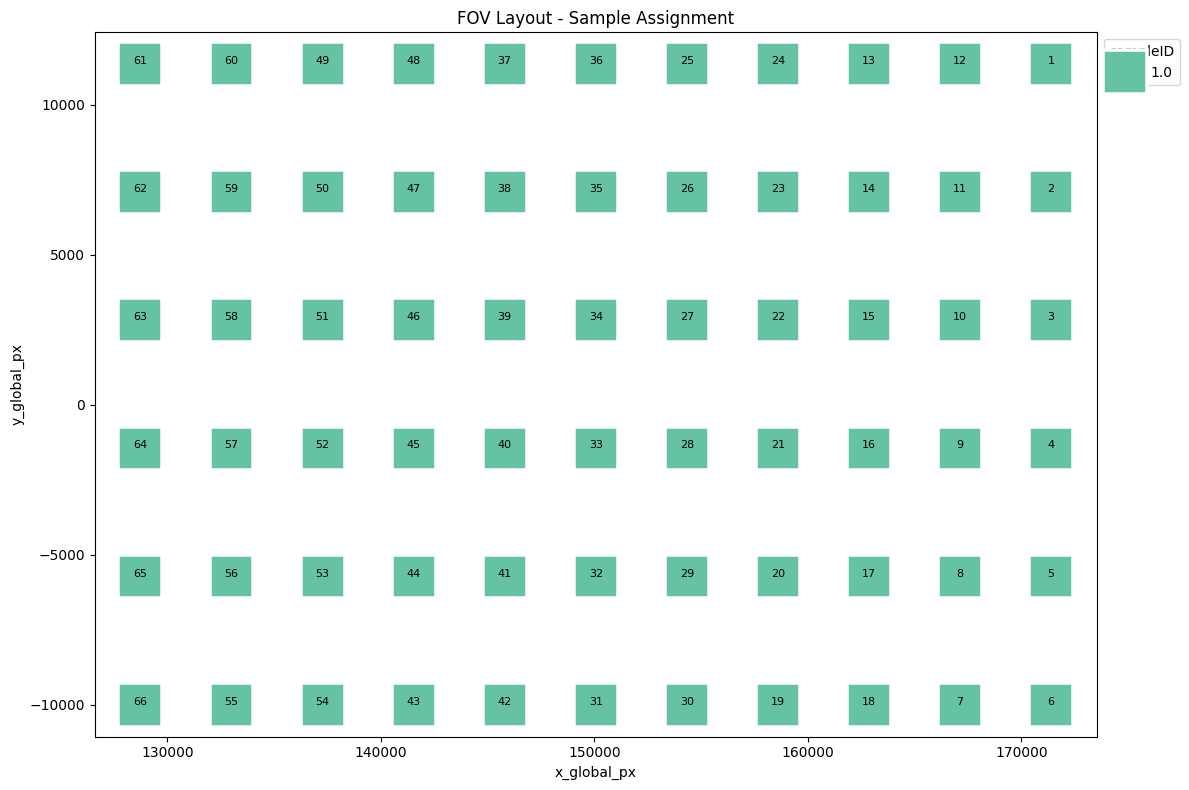

✓ FOV layout saved to 'FOV_layout.png'


In [26]:
# Plot FOV positions colored by sample
plt.figure(figsize=(12, 8))
plt.style.use('default')
plt.grid(False)

g = sns.scatterplot(
    x="x_global_px", 
    y="y_global_px", 
    s=1000, 
    marker='s',
    data=fovfile_df, 
    hue='sampleID', 
    palette="Set2"
)

# Add FOV numbers as labels
for _, row in fovfile_df.iterrows():
    plt.text(
        row["x_global_px"],
        row["y_global_px"],
        str(int(row["fov"])),
        ha='center',
        fontsize=8
    )

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.title("FOV Layout - Sample Assignment")
plt.tight_layout()
plt.savefig('FOV_layout.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ FOV layout saved to 'FOV_layout.png'")

### Merge Sample IDs to Cell Data

In [27]:
# Merge sample IDs from FOV file to cell metadata
adata.obs['fov'] = adata.obs['fov'].astype(int)
merged_df = pd.merge(adata.obs, fovfile_df[['fov', 'sampleID']], on='fov', how='left')
adata.obs['sampleID'] = list(merged_df['sampleID'])

print("Sample distribution:")
print(adata.obs['sampleID'].value_counts().sort_index())

Sample distribution:
sampleID
1.0    38996
Name: count, dtype: int64


---
## 5. Basic Spatial Visualization

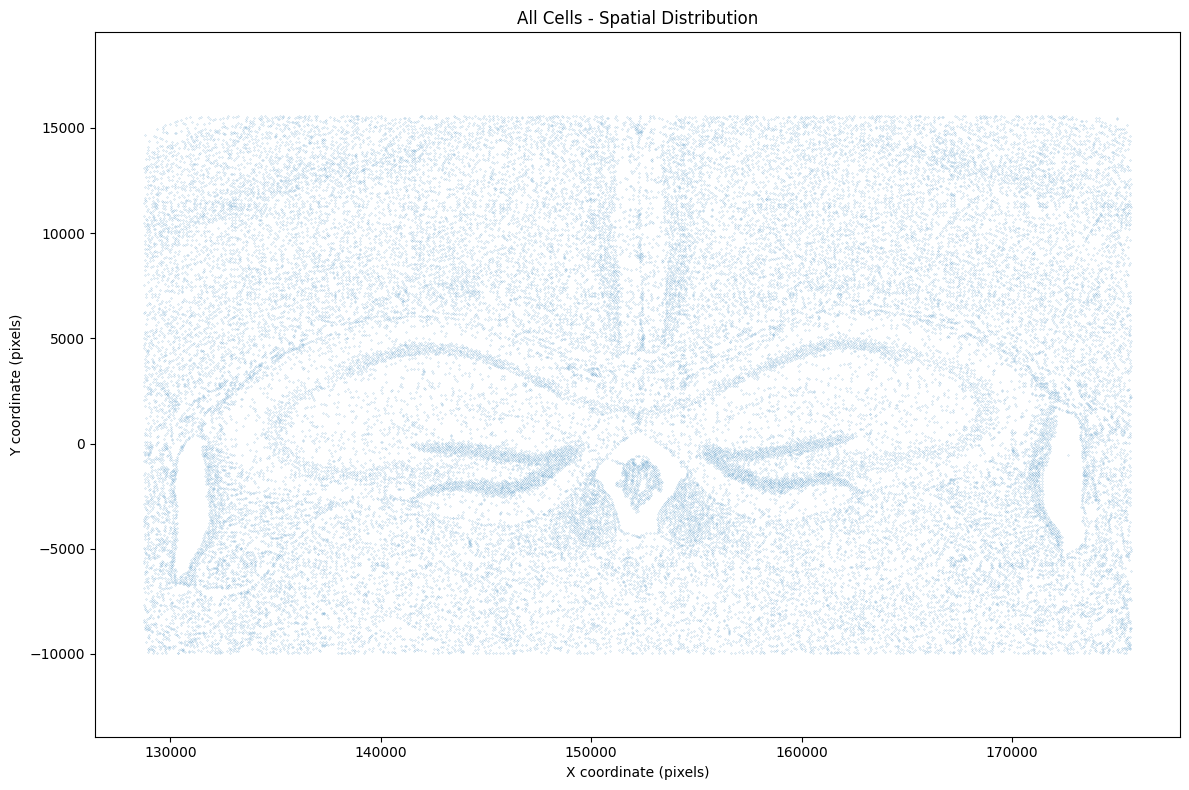

✓ Spatial distribution saved


In [30]:
# Extract global coordinates
xy = adata.obsm['global']
adata.obs['x_global_px'] = xy[:, 0]
adata.obs['y_global_px'] = xy[:, 1]

# Plot all cells
plt.figure(figsize=(12, 8))
plt.scatter(
    adata.obs['x_global_px'], 
    adata.obs['y_global_px'], 
    s=0.1, 
    marker='.', 
    alpha=0.75
)
plt.title("All Cells - Spatial Distribution")
plt.xlabel("X coordinate (pixels)")
plt.ylabel("Y coordinate (pixels)")
plt.axis('equal')
plt.tight_layout()
plt.savefig('cells_spatial_distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Spatial distribution saved")

---
## 6. Quality Control Metrics

CosMx includes **negative control probes** to assess background:
- **Negative DNA probes** - Probes with no target in the genome
- **System Control probes** - Technical controls

Good quality data typically has <5% negative probe counts.

In [31]:
# Identify control probes
adata.var["NegPrb"] = adata.var_names.str.startswith("Negative")
adata.var["SysControl"] = adata.var_names.str.startswith("SystemControl")

print(f"Negative probes: {adata.var['NegPrb'].sum()}")
print(f"System control probes: {adata.var['SysControl'].sum()}")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["NegPrb"], inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=["SysControl"], inplace=True)

# Calculate percentages
negprobes = adata.obs["total_counts_NegPrb"].sum() / adata.obs["total_counts"].sum() * 100
syscontrolprobes = adata.obs["total_counts_SysControl"].sum() / adata.obs["total_counts"].sum() * 100

print(f"\n{'='*50}")
print(f"Negative DNA probe count %: {negprobes:.2f}%")
print(f"System Control probe count %: {syscontrolprobes:.2f}%")
print(f"{'='*50}")

if negprobes > 5:
    print("⚠️  Warning: Negative probe percentage is high (>5%)")
else:
    print("✓ Negative probe percentage is acceptable (<5%)")

Negative probes: 0
System control probes: 0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



Negative DNA probe count %: 0.00%
System Control probe count %: 0.00%
✓ Negative probe percentage is acceptable (<5%)


### Remove System Control Probes

In [32]:
# Remove system control probes (keep negative probes for QC)
selected_genes = ~adata.var_names.str.contains("SystemControl")
adata = adata[:, selected_genes].copy()

print(f"After removing system controls: {adata.shape}")

After removing system controls: (38996, 960)


---
## 7. QC Plots - Cell-Level Statistics

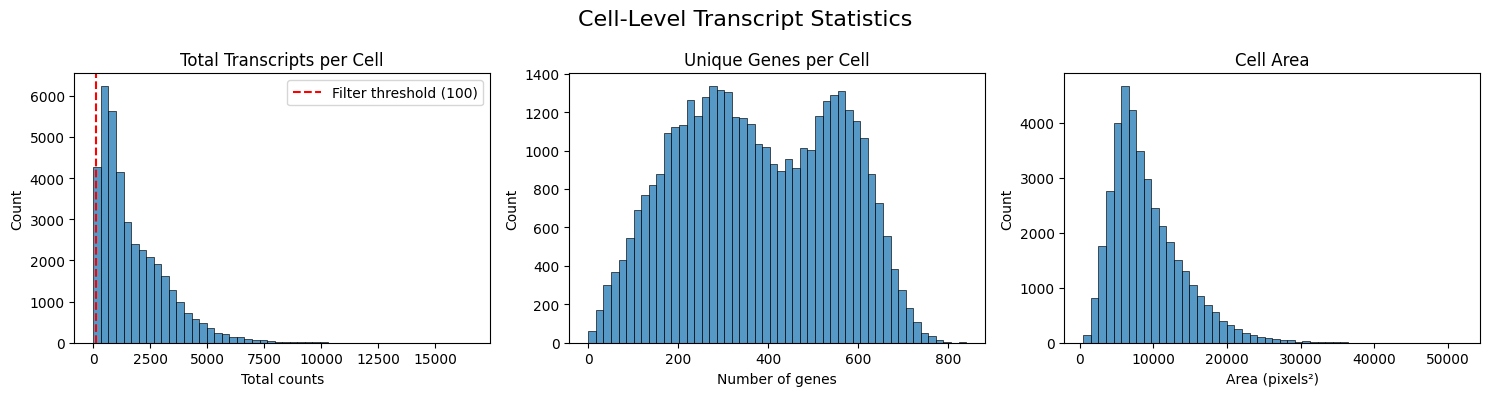

✓ Cell statistics saved


In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Cell-Level Transcript Statistics', fontsize=16)

# Total transcripts per cell
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0], bins=50)
axs[0].set_title("Total Transcripts per Cell")
axs[0].set_xlabel("Total counts")
axs[0].axvline(100, color='r', linestyle='--', label='Filter threshold (100)')
axs[0].legend()

# Unique genes per cell
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1], bins=50)
axs[1].set_title("Unique Genes per Cell")
axs[1].set_xlabel("Number of genes")

# Cell area
sns.histplot(adata.obs["Area"], kde=False, ax=axs[2], bins=50)
axs[2].set_title("Cell Area")
axs[2].set_xlabel("Area (pixels²)")

plt.tight_layout()
plt.savefig('cell_statistics.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cell statistics saved")

### QC Plots - FOV-Level Statistics

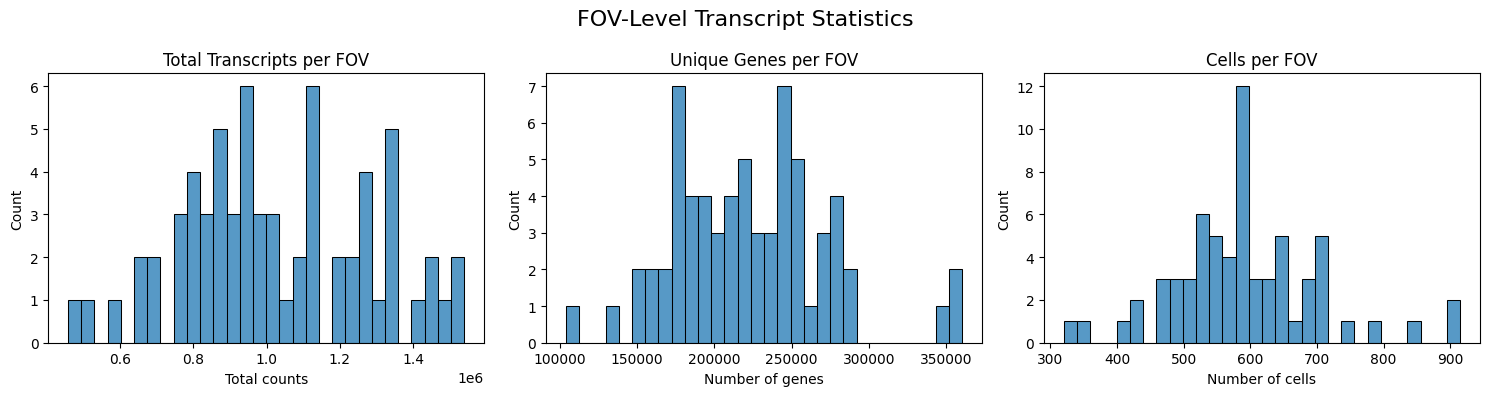

✓ FOV statistics saved


In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('FOV-Level Transcript Statistics', fontsize=16)

# Total transcripts per FOV
fov_total = adata.obs.groupby("fov")["total_counts"].sum()
sns.histplot(fov_total, kde=False, ax=axs[0], bins=30)
axs[0].set_title("Total Transcripts per FOV")
axs[0].set_xlabel("Total counts")

# Unique genes per FOV
fov_genes = adata.obs.groupby("fov")["n_genes_by_counts"].sum()
sns.histplot(fov_genes, kde=False, ax=axs[1], bins=30)
axs[1].set_title("Unique Genes per FOV")
axs[1].set_xlabel("Number of genes")

# Cells per FOV
fov_cells = adata.obs.groupby("fov").size()
sns.histplot(fov_cells, kde=False, ax=axs[2], bins=30)
axs[2].set_title("Cells per FOV")
axs[2].set_xlabel("Number of cells")

plt.tight_layout()
plt.savefig('fov_statistics.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ FOV statistics saved")

---
## 8. Filtering and Normalization

**Filtering criteria:**
- Remove cells with <100 total transcripts
- Remove genes detected in <1000 cells (adjust based on your data)

**Note:** These thresholds should be adjusted based on your QC plots above.

In [35]:
print(f"Original dimensions: {adata.shape}")

# Filter cells
sc.pp.filter_cells(adata, min_counts=100)
print(f"After filtering cells (min_counts=100): {adata.shape}")

# Filter genes
sc.pp.filter_genes(adata, min_cells=1000)
print(f"After filtering genes (min_cells=1000): {adata.shape}")

# Store raw counts
adata.layers["counts"] = adata.X.copy()

# Normalize and log-transform
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

print("\n✓ Filtering and normalization complete!")

Original dimensions: (38996, 960)
After filtering cells (min_counts=100): (38251, 960)
After filtering genes (min_cells=1000): (38251, 960)

✓ Filtering and normalization complete!


---
## 9. Dimensionality Reduction and Clustering

Standard single-cell analysis workflow:
1. **PCA** - Principal component analysis
2. **Neighbors** - K-nearest neighbors graph
3. **UMAP** - Uniform Manifold Approximation and Projection
4. **Leiden** - Community detection clustering

In [36]:
print("Running dimensionality reduction...")

# PCA
sc.pp.pca(adata)
print("✓ PCA complete")

# Neighbors
sc.pp.neighbors(adata)
print("✓ Neighbor graph computed")

# UMAP
sc.tl.umap(adata)
print("✓ UMAP complete")

# Leiden clustering
sc.tl.leiden(adata)
print(f"✓ Leiden clustering complete - {len(adata.obs['leiden'].unique())} clusters")

Running dimensionality reduction...
✓ PCA complete
✓ Neighbor graph computed
✓ UMAP complete
✓ Leiden clustering complete - 32 clusters


### UMAP Visualization

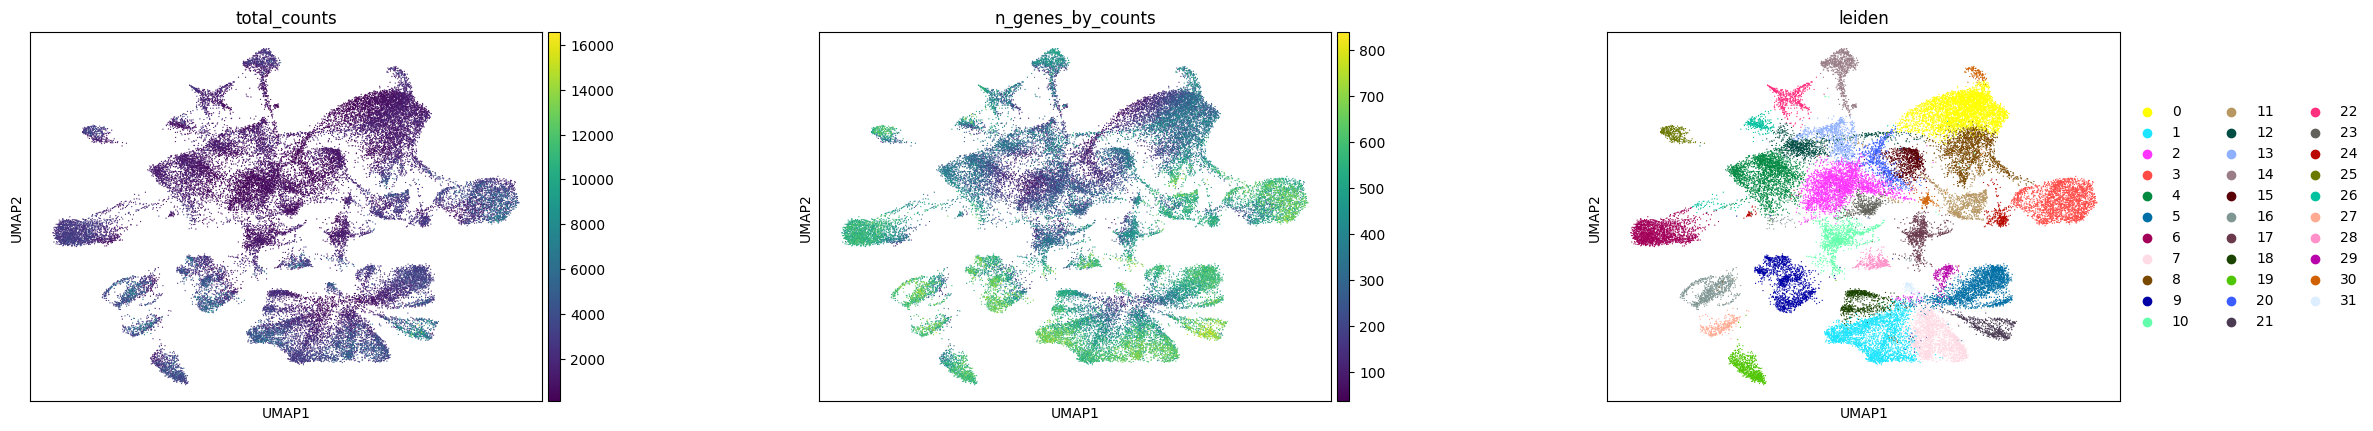

✓ UMAP plots saved


In [37]:
# UMAP colored by QC metrics and clusters
sc.pl.umap(
    adata, 
    color=["total_counts", "n_genes_by_counts", "leiden"], 
    wspace=0.4,
    save='_cosmx_qc.png'
)

print("✓ UMAP plots saved")

---
## 10. Spatial Visualization of Clusters

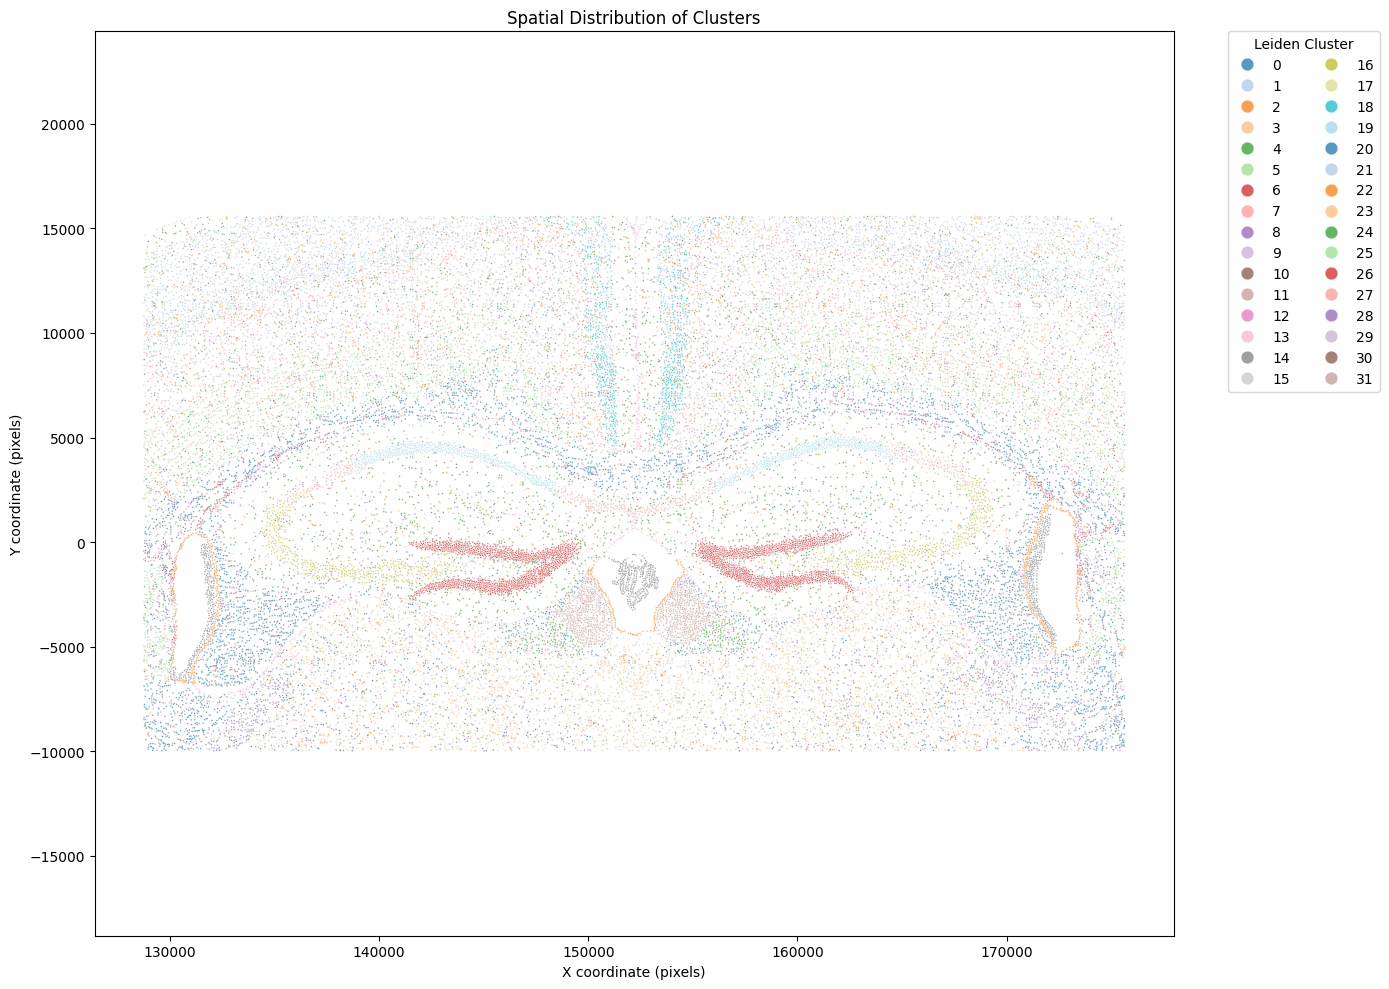

✓ Spatial cluster plot saved


In [41]:
# Plot clusters in spatial context
plt.figure(figsize=(14, 10))

g = sns.scatterplot(
    x="x_global_px", 
    y="y_global_px", 
    s=5, 
    marker='.',
    data=adata.obs, 
    hue='leiden', 
    palette="tab20",
    alpha=0.75
)

# Adjust legend
handles, labels = g.get_legend_handles_labels()
for h in handles:
    h.set_markersize(h.get_markersize() * 8)

plt.legend(
    handles, 
    labels, 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    borderaxespad=0,
    ncol=2,
    title='Leiden Cluster'
)

plt.title("Spatial Distribution of Clusters")
plt.xlabel("X coordinate (pixels)")
plt.ylabel("Y coordinate (pixels)")
plt.axis('equal')
plt.tight_layout()
plt.savefig('spatial_clusters.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

print("✓ Spatial cluster plot saved")

---
## 11. Visualize Specific FOV

For detailed inspection of segmentation quality, visualize individual FOVs.

Visualizing FOV 32...
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                

FOV visualization complete!
The plot shows:
  1. Images - Raw fluorescence images
  2. Labels - Segmented cell masks
  3. Points - Individual transcript locations
  4. Shapes - Cell boundary polygons


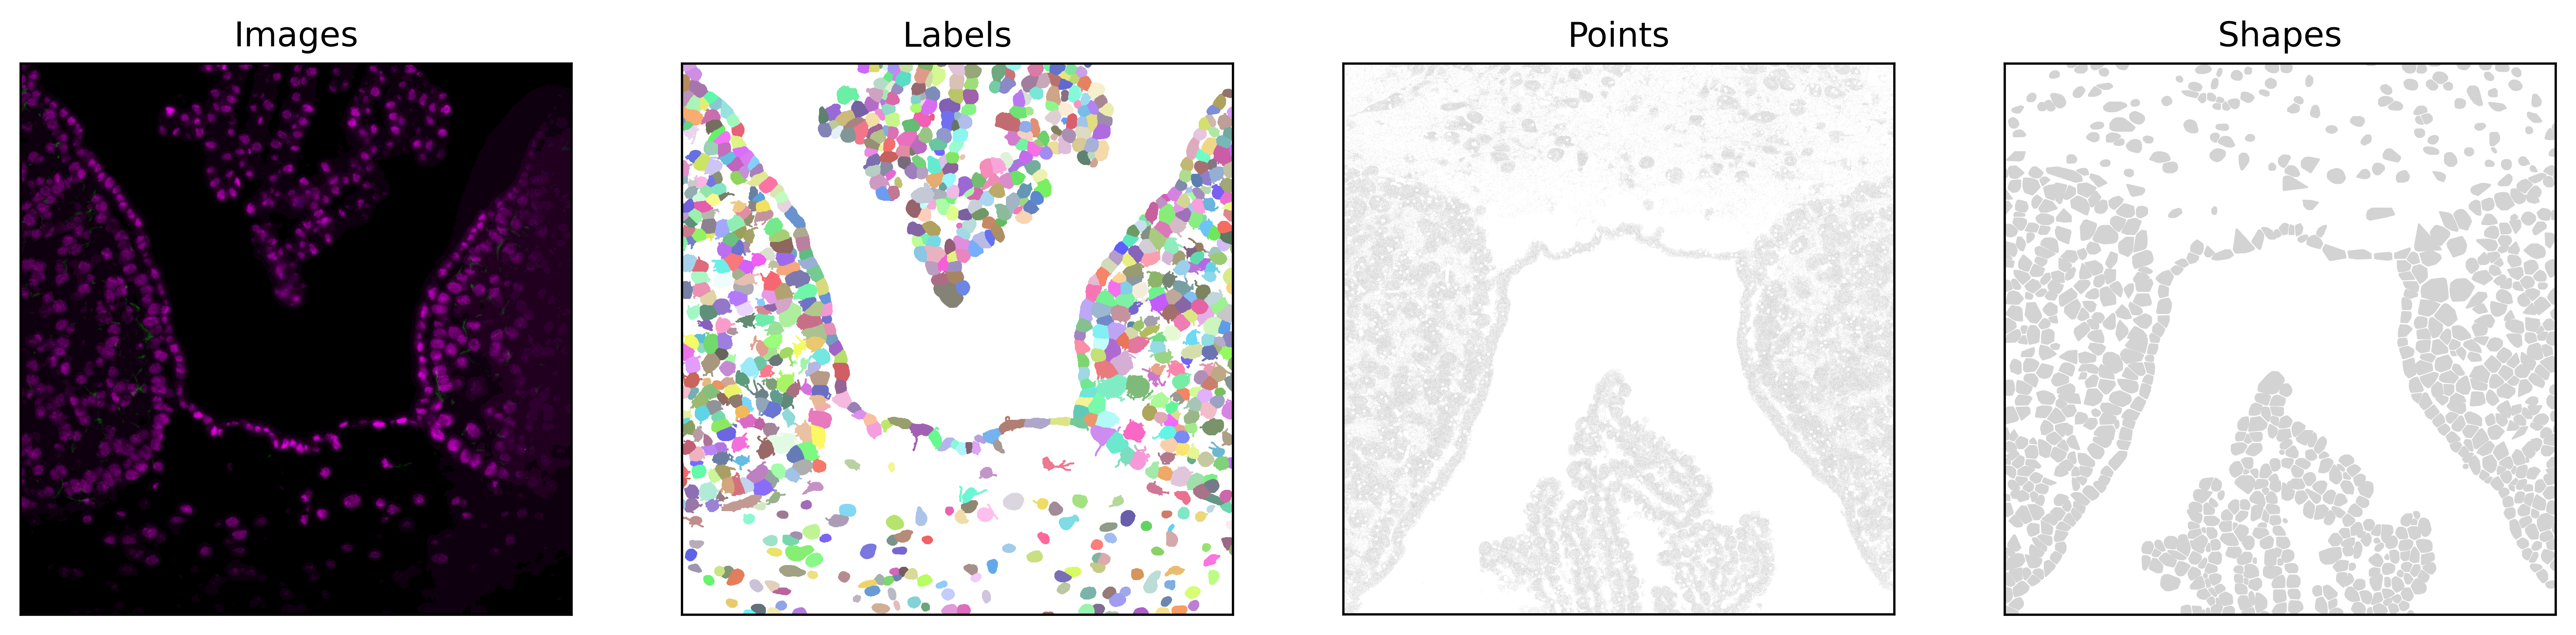

In [39]:
# TODO: Change this to the FOV you want to visualize
fov_to_visualize = '32'

print(f"Visualizing FOV {fov_to_visualize}...")
visualise_fov(sdata, fov_to_visualize, coordinate='global')

print("\nFOV visualization complete!")
print("The plot shows:")
print("  1. Images - Raw fluorescence images")
print("  2. Labels - Segmented cell masks")
print("  3. Points - Individual transcript locations")
print("  4. Shapes - Cell boundary polygons")

---
## 12. Save Processed Data

In [ ]:
# Save processed AnnData object
adata.write_h5ad("processed_cosmx_data.h5ad")
print("✓ Processed data saved to 'processed_cosmx_data.h5ad'")

# Save cluster assignments
cluster_df = adata.obs[['fov', 'sampleID', 'leiden', 'x_global_px', 'y_global_px']].copy()
cluster_df.to_csv("cell_clusters.csv")
print("✓ Cluster assignments saved to 'cell_clusters.csv'")

# Save the QC zarr
sdata.write("CosMx_data_QC.zarr")
print("✓ QC zarr file saved")

✓ Processed data saved to 'processed_cosmx_data.h5ad'
✓ Cluster assignments saved to 'cell_clusters.csv'
INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside CosMx_data_QC.zarr). Please see the documentation of `is_self_contained()` to understand
         the implications of working with SpatialData objects that are not self-contained.                         
INFO     The Zarr backing store has been changed from CosMx_data.zarr the new file path: CosMx_data_QC.zarr        
✓ QC zarr file saved'


---
## 13. Optional: Resegmentation with Cellpose

If the default segmentation quality is poor, you can improve it using Cellpose.

**Requirements:**
- `reseg.py` module
- `reseg_tools.py` module
- Cellpose installed (`pip install cellpose`)

**Warning:** This is computationally intensive and may take hours for large datasets!

In [ ]:
# Uncomment to run resegmentation

# from reseg_tools import stitching, vis_segmentation, qc_metric, qc_plot, filter_norm
# from reseg import Resegmentation

# # Define sample FOVs to stitch
# sample1 = list(range(1, 72 + 1))
# template = ['_image', '_labels', '_shapes', '_points']
# S1 = [str(a) + b for a in sample1 for b in template]

# # Subset and stitch FOVs
# sdata_S1 = sdata.subset(element_names=S1, include_orphan_tables=False)
# stitching(sdata_S1, fovfile_df, name="S1")

# # Run Cellpose resegmentation
# pipe = Resegmentation(
#     path=path,
#     zarr_name='stitched_S1.zarr',
#     output='Stitched_segmentation_ready.png',
#     factor_rescale=8,
#     image_name='Stitched',
#     label_name='labels',
#     shape_name='shapes',
#     point_name='points'
# )

# pipe.preprocess_image(channel_names=['B', 'G', 'Y', 'R', 'U'], channels_to_use=['U'])
# pipe.run_cellpose(flow_threshold=1.2, cellprob_threshold=-3, tile_overlap=0.15)
# pipe.update_spatialdata()

# print("✓ Resegmentation complete!")

---
## Summary

This notebook covered:

1. ✓ Loading CosMx data from flat files
2. ✓ FOV visualization and sample assignment
3. ✓ Quality control metrics (negative probes)
4. ✓ Cell and gene filtering
5. ✓ Normalization and log-transformation
6. ✓ Dimensionality reduction (PCA, UMAP)
7. ✓ Clustering (Leiden)
8. ✓ Spatial visualization
9. ✓ Optional resegmentation

## Next Steps

- **Marker gene analysis:** Use `sc.tl.rank_genes_groups()` to find cluster markers
- **Cell type annotation:** Annotate clusters based on marker genes
- **Spatial analysis:** Neighborhood enrichment, spatial statistics
- **Differential expression:** Compare gene expression between samples/conditions

## References

- [SpatialData Documentation](https://spatialdata.scverse.org/)
- [Scanpy Documentation](https://scanpy.readthedocs.io/)
- [CosMx Platform](https://nanostring.com/products/cosmx-spatial-molecular-imager/)